In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from talib import abstract

from functools import partial

In [2]:
#Download Data from yahoo
### TEST Scnarios - TCS- Bull ,ACC- modrate up (Sidewase),YESBank- Back to Zero ,ITC(stock dosnt even Move)
stock='TCS'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

[*********************100%***********************]  1 of 1 completed


## Note that if α=1, the SES model is equivalent to a random walk model (without growth). If α=0, the SES model is equivalent to the mean model, assuming that the first smoothed value is set equal to the mean.

In [3]:
# #
# def rwema(windows,df1,field):
#     for window in windows:
#         alpha=1/window
#         weights=list(reversed([(1)**n for n in range(window)]))
#         weights_T=list(reversed([(1-alpha)**n for n in range(window)]))
#         ewma = partial(np.average, weights=weights)
#         ewma_T = partial(np.average, weights=weights_T)
#         df1[f'{window}RWEMA'] = df1[field].rolling(window).apply(ewma)
#         df1[f'{window}RWEMA_T'] = df1[field].rolling(window).apply(ewma_T)
#         df1[f'{window}rma_a_dis']=((df1[f'{window}RWEMA_T']/df1[f'{window}RWEMA'])-1)*100
#         df1.dropna(inplace=True)
#     return df1

In [4]:
#
def rwema(windows,df1,field):
    for window in windows:
        df1[f'{window}RWEMA'] = df1[field].rolling(window).mean()
        df1.dropna(inplace=True)
    return df1

In [5]:
def madisparity(window,df2,field):
    for window in windows:
        df2[str(window)+field]=((df2[field]-df2[field].rolling(window).mean())/df2[field].rolling(window).mean())*100
        # df.replace(to_replace=np.nan,method='bfill',inplace=True)
        df2.dropna(inplace=True)
    return df2

In [6]:
## Making Copy of Dataframe for further analysis and changes
df=dfo.copy()
# Adding feild called % Daily changes out of 100%
df['pct_change']=(df['Close'].pct_change())*100
df.dropna(inplace=True)

windows=[378,252,189,126,105,84,63,42,21,10]
df1=rwema(windows,df,'Close')


In [7]:
## Making Copy of Dataframe for further analysis and changes
df=dfo.copy()
# Adding feild called % Daily changes out of 100%
df['pct_change']=(df['Close'].pct_change())*100
df.dropna(inplace=True)

windows=[378,252,189,126,105,84,63,42,21,10]
df2=madisparity(windows,df,'Close')

In [8]:
df1['UMA']=(df1[f'{windows[0]}RWEMA']+df1[f'{windows[1]}RWEMA']+df1[f'{windows[2]}RWEMA']+df1[f'{windows[3]}RWEMA']+df1[f'{windows[4]}RWEMA']+df1[f'{windows[5]}RWEMA']+df1[f'{windows[6]}RWEMA']+df1[f'{windows[7]}RWEMA']+df1[f'{windows[8]}RWEMA']+df1[f'{windows[9]}RWEMA'])/10
df2['UMA']=(df2[f'{windows[0]}Close']+df2[f'{windows[1]}Close']+df2[f'{windows[2]}Close']+df2[f'{windows[3]}Close']+df2[f'{windows[4]}Close']+df2[f'{windows[5]}Close']+df2[f'{windows[6]}Close']+df2[f'{windows[7]}Close']+df2[f'{windows[8]}Close']+df2[f'{windows[9]}Close'])/10

In [9]:
df2['UMAB0']=np.where(df2['UMA']<0,df2['UMA'],0)
df2['UMAB0']=np.where(df2['UMAB0']==0,df2['UMAB0'].rolling(252).min(),df2['UMAB0'])
# df2['UMAB0'].replace(to_replace=0,method='ffill',inplace=True)

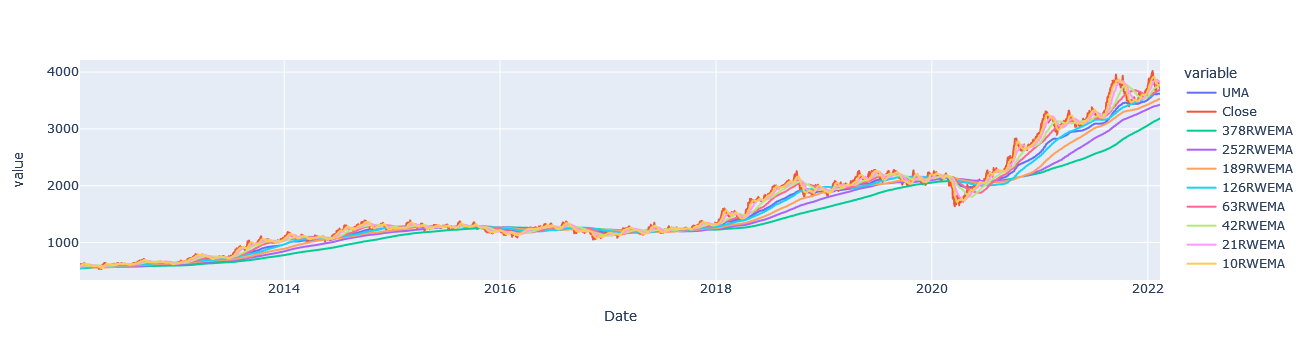

In [10]:
fig=px.line(df1[['UMA','Close','378RWEMA','252RWEMA','189RWEMA','126RWEMA','63RWEMA','42RWEMA','21RWEMA','10RWEMA']])
fig.show()

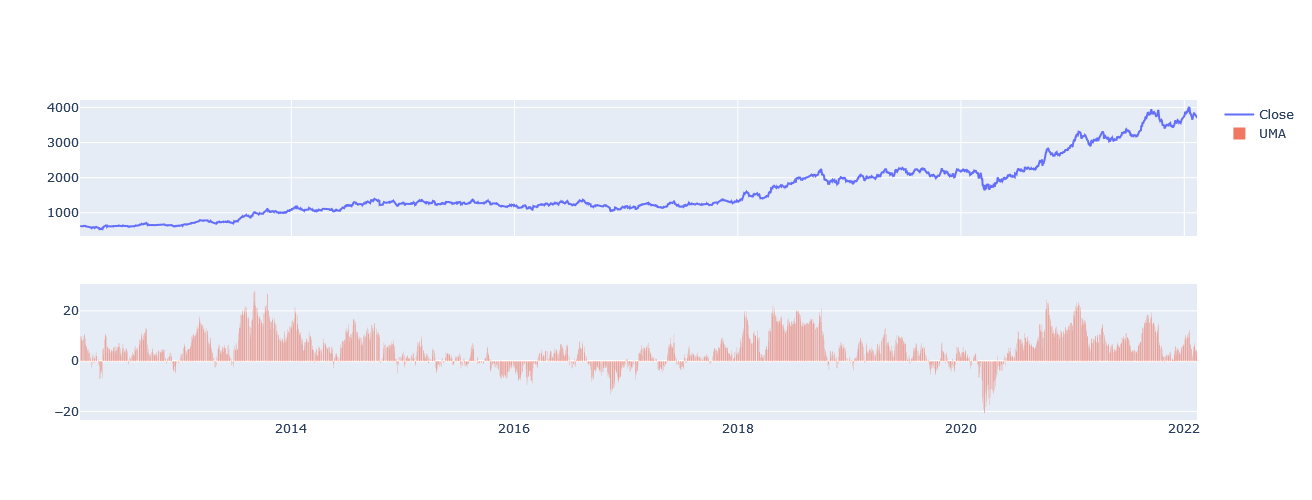

In [11]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True)
trace0 = go.Scatter(x=df2.index,y=df1['Close'],mode='lines',name='Close')
trace1 = go.Bar(x=df2.index,y=df2['UMA'],name='UMA',opacity=0.8)
# trace2 = go.Bar(x=df2.index,y=df2['UMAB0'],name='UMAB0',opacity=0.8)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
# fig.append_trace(trace2, 3, 1)
fig.update_traces(dict(marker_line_width=0))
fig.update_layout(autosize=False,width=1200,height=500,paper_bgcolor="white",barmode='overlay',activeshape_opacity=0.5)
fig.show()


In [12]:
def mov(bins,df,field):
    temp=bins
    #temp=[-500,-400,-300,-200,-100,-50,-30,-20,-15,-10,-5,-2,-1,0,1,2,5,10,15,20,30,50,100,200,300,400,500]
    len(temp) #--13
    range(len(temp)) #--(0,13)
    temp.index(0) #-- Zero at 6th Index
    neg={}
    pos={}


    for i in range(0,temp.index(0)):
        # print(i+1+temp.index(0),temp.index(0)-1-i)
        # print(f" Searching from {temp[temp.index(0)]} to {temp[temp.index(0)-1-i]}")
        tempcountneg=df[field].loc[(df[field]>temp[temp.index(0)-1-i])&(df[field]<temp[temp.index(0)])].count()
        neg[f"{temp[temp.index(0)]} - {temp[temp.index(0)-1-i]}"]=tempcountneg
        # neglist.append(tempcountneg*-1)

        # print(f" Searching from {temp[temp.index(0)]} to {temp[i+1+temp.index(0)]}")
        tempcountpos=df[field].loc[(df[field]<temp[i+1+temp.index(0)])&(df[field]>temp[temp.index(0)])].count()
        pos[f"{temp[temp.index(0)]} - {temp[i+1+temp.index(0)]}"]=tempcountpos
        # poslist.append(tempcountpos)
    negdf=pd.DataFrame(neg,index=[0])
    posdf=pd.DataFrame(pos,index=[0]) 

    ## .iloc[::-1] to reverse the Dataframe
    # negdf=negdf.T.iloc[::-1]
    negdf=negdf.T
    posdf=posdf.T

    #######Setting the coulmns
    negdf.reset_index(inplace=True)
    negdf.columns=['Range','Total']
    negdf.set_index('Range',inplace=True)

    posdf.reset_index(inplace=True)
    posdf.columns=['Range','Total']
    posdf.set_index('Range',inplace=True)

    ######Calculating total change between days
    negdf['Diff']=abs(negdf['Total']-negdf['Total'].shift(1))
    negdf.replace(to_replace=np.nan,value=0,inplace=True)
    negdf['%Reach']=abs((negdf['Diff']/negdf['Total'][temp.index(0)-1])*100)
    # print(negdf['Total'][temp.index(0)-1])


    posdf['Diff']=abs(posdf['Total']-posdf['Total'].shift(1))
    posdf.replace(to_replace=np.nan,value=0,inplace=True)
    posdf['%Reach']=abs((posdf['Diff']/posdf['Total'][temp.index(0)-1])*100)
    # print(posdf['Total'][temp.index(0)-1])

    ######Reversing the datatable
    negdf=negdf.iloc[::-1]

    newdf=negdf.append(posdf)
    return newdf

    # df['RWEMA_252_movement'].loc[(df['RWEMA_252_movement']>-15)&(df['RWEMA_252_movement']<0)].count()

In [13]:
def backtester(start,end,init_df,trade_type,ma):
    bt=pd.DataFrame({'StartDate':start,'EndDate':end})
    bt.replace(to_replace=np.nan,value=0,inplace=True)
    
    dataframes=[]
    pc_=[]
    
    if trade_type=='long':
        
        for index in bt.index:
            init_df_tmp=(init_df.loc[(init_df.index>=bt['StartDate'][index]) & (init_df.index<=bt['EndDate'][index])]).copy()
            ## Setting up Default Variables
            pos=0
            num=0
            percentchange=[]
            day_count=0
            init_df_tmp['pos_days']=0
            init_df_tmp['s_daily_change']=0.0
            init_df_tmp['u_daily_Return']=0.0
            s_st=[]
            trigger_p=[]
            lastpc=[0,]
            
            s_start=0
            #### price at time of start date of this stratgy
            u_st=init_df_tmp['Close'][0]
            
            for i in init_df_tmp.index:
                CP=init_df_tmp['Close'][i]
                # Underline Daily return from the start date of Stratgy
                if s_start!=0:
                    init_df_tmp.at[i,'u_daily_Return']=init_df_tmp['pct_change'][i]
                
                if i != init_df_tmp.index[9]:##############3 Passing first 10 Days

                    #############Conditions######################
                    #############Long Position###################
                    long_condition=((init_df_tmp['UMA'][i]> init_df_tmp['UMA'].shift(5)[i]) & (init_df_tmp['UMA'].shift(5)[i]< -5.0)) | ((init_df_tmp['UMA'][i]> init_df_tmp['UMA'].shift(5)[i]) & (init_df_tmp['UMA'].shift(5)[i]< -10.0))|((init_df_tmp['UMA'][i]> init_df_tmp['UMA'].shift(5)[i]) & (init_df_tmp['UMA'].shift(5)[i]< -20.0))         
                    #############Long SL/Exit#########################
                    long_exit= ((init_df_tmp['UMA'][i]< init_df_tmp['UMA'].shift(5)[i]) & (init_df_tmp['UMA'][i] < -5.0))
                    
                    #############Short SL/Exit#########################
                
                  
                    
                    ## Enter into Long
                    if not s_st:
                        if long_condition:                
                            if(pos==0):
                                print(f"Long Buy Triggred")
                                s_start=1
                                bp=CP
                                pos=1
                                print(f"Buying now at {str(bp)} on {i}")
                                init_df_tmp.at[i,'pos_days']=day_count
                                if not s_st: # to check if any long or short position already triggred or not. if s_st have value ,means already atleast one trade happned.
                                    s_st.append(bp)
                    if s_st:
                        if(pos==1):
                            day_count+=1
                            init_df_tmp.at[i,'pos_days']=day_count
                            init_df_tmp.at[i,'s_daily_change']=init_df_tmp['pct_change'][i]

                    ## Long SL/Exit       
                        if long_exit:                
                            if(pos==1):
                                print("Long Covering Triggred")
                                day_count=0
                                pos=0
                                sp=CP
                                print(f"Existing now at {str(sp)} on {i}")
                                pc=(sp/bp-1)*100
                                percentchange.append(pc)
                                init_df_tmp.at[i,'pos_days']=day_count
                                s_st.clear()


                        if(num==init_df_tmp["Close"].count()-1 and pos==1):
                            pos=0
                            sp=CP
                            day_count=0
                            print(f"Existing now at {str(sp)} on {i}")
                            pc=(sp/bp-1)*100
                            percentchange.append(pc)
                            init_df_tmp.at[i,'pos_days']=day_count
                            s_st.clear()


                num+=1    
                pc_.append(percentchange)

                #################################for Performance Matrix############
                # Stratgy Cummulative returns and Underline Cummulative returns
                init_df_tmp['scr']=((1+(init_df_tmp['s_daily_change']/100)).cumprod()-1)*100
                init_df_tmp['ucr']=((1+(init_df_tmp['u_daily_Return']/100)).cumprod()-1)*100        
                
                gains=0
                ng=0
                losses=0
                nl=0
                for i in percentchange:
                    if(i>0):
                        gains+=i
                        ng+=1
                    else:
                        losses+=i
                        nl+=1

                if(ng>0):
                    avgGain=gains/ng
                    maxR=max(percentchange)
                else:
                    avgGain=0
                    maxR=0

                if(nl>0):
                    avgLoss=losses/nl
                    maxL=min(percentchange)
                    ratio=-avgGain/avgLoss
                else:
                    avgLoss=0
                    maxL=0
                    ratio=999

                if(ng>0 or nl>0):
                    battingAvg=(ng/(ng+nl))*100
                else:
                    battingAvg=0
                ### Adding matrix to BackTEST Dataframe#####
                bt.at[index,'MA']=ma
                bt.at[index,'#Trades']=ng+nl
                bt.at[index,'Win avg']=round(battingAvg,2)
                bt.at[index,'#Wins']=ng
                bt.at[index,'#loss']=nl
                bt.at[index,'Gain/loss ratio']=round(ratio,2)
                bt.at[index,'Average Gain %']=round(avgGain,2)
                bt.at[index,'Average Loss %']=round(avgLoss,2)
                bt.at[index,'Max Return %']=round(maxR,2)
                bt.at[index,'Max Loss %']=round(maxL,2)
                bt.at[index,'Stratergy-Cum Total return %']=round(init_df_tmp['scr'][-1],2)
                bt.at[index,'Underline-Cum Total return %']=round(init_df_tmp['ucr'][-1],2)

                ## Adding Result Dataframe into List of Dataframes
                dataframes.append(init_df_tmp)
                
    return bt,dataframes

### 71% compare to 45% for ACC from 2010,2020
#############Long Position###################
#### long_condition=(init_df_tmp['189rma_a_dis'][i]> init_df_tmp['189rma_a_dis'].shift(9)[i]) & (init_df_tmp['189rma_a_dis'].shift(1)[i]< -0.5)
#############Long Exit##############
#### long_exit=(init_df_tmp['126rma_a_dis'][i]< init_df_tmp['189rma_a_dis'].shift(9)[i])


In [30]:
df=dfo.copy()
# Adding feild called % Daily changes out of 100%
df['pct_change']=(df['Close'].pct_change())*100
df.dropna(inplace=True)

windows=[378,252,189,126,105,84,63,42,21,10]
df2=madisparity(windows,df,'Close')
df2['UMA']=(df2[f'{windows[0]}Close']+df2[f'{windows[1]}Close']+df2[f'{windows[2]}Close']+df2[f'{windows[3]}Close']+df2[f'{windows[4]}Close']+df2[f'{windows[5]}Close']+df2[f'{windows[6]}Close']+df2[f'{windows[7]}Close']+df2[f'{windows[8]}Close']+df2[f'{windows[9]}Close'])/10

start=['2018-01-01']
end=['2020-01-01']
result,result_dataframes=backtester(start=start,end=end,init_df=df2,trade_type='long',ma=200)

Long Buy Triggred
Buying now at 2099.300048828125 on 2019-09-30 00:00:00
Long Covering Triggred
Existing now at 1986.8499755859375 on 2019-10-11 00:00:00
Long Buy Triggred
Buying now at 2057.35009765625 on 2019-10-18 00:00:00
Existing now at 2167.60009765625 on 2020-01-01 00:00:00


In [31]:
result

StartDate     EndDate     MA  #Trades  Win avg  #Wins  #loss  \
0  2018-01-01  2020-01-01  200.0      2.0     50.0    1.0    1.0   

   Gain/loss ratio  Average Gain %  Average Loss %  Max Return %  Max Loss %  \
0              1.0            5.36           -5.36          5.36       -5.36   

   Stratergy-Cum Total return %  Underline-Cum Total return %  
0                          3.13                          3.25

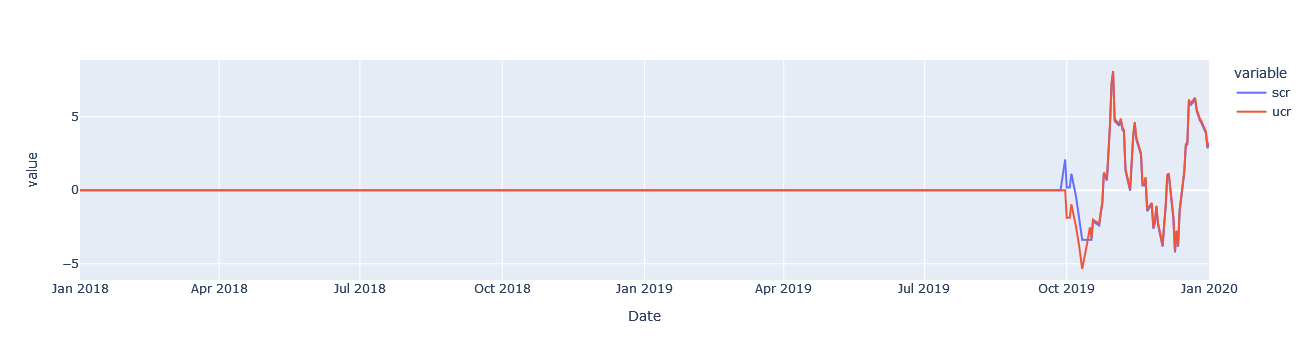

In [32]:
result_df=result_dataframes[0]
fig=px.line(result_df[['scr','ucr']],)
fig.show()

In [17]:
result_df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-02-10   614.000000   619.000000   606.000000   616.700012   509.218719   
2012-02-13   611.099976   618.974976   607.000000   612.849976   506.039429   
2012-02-14   612.500000   614.775024   607.500000   610.000000   503.686157   
2012-02-15   613.575012   624.400024   609.750000   620.799988   512.603821   
2012-02-16   619.000000   621.000000   609.000000   612.674988   505.894867   
...                 ...          ...          ...          ...          ...   
2021-12-27  3671.000000  3700.000000  3653.100098  3696.100098  3689.616699   
2021-12-28  3710.000000  3725.000000  3693.850098  3706.550049  3700.048340   
2021-12-29  3692.250000  3719.949951  3685.000000  3694.699951  3688.218994   
2021-12-30  3681.350098  3740.000000  3680.000000  3733.750000  3727.200684   
2021-12-31  3742.800049  3760.000000  3731.300049  3738.350098  3731.792725   

             Volume  pct_change   378Close   252Close   189Close  ...  \
Date                                                              ...   
2012-02-10  2324302    0.390693  13.824667  10.584497  11.311260  ...   
2012-02-13  1631770   -0.624297  13.018083   9.864064  10.571047  ...   
2012-02-14  1826646   -0.465036  12.395096   9.318608  10.014974  ...   
2012-02-15  2167166    1.770490  14.284279  11.208015  11.893455  ...   
2012-02-16  1886660   -1.308795  12.689512   9.702991  10.377289  ...   
...             ...         ...        ...        ...        ...  ...   
2021-12-27  1534135    0.686485  21.378385  10.879723   8.214376  ...   
2021-12-28  1456218    0.282729  21.545809  11.076004   8.425608  ...   
2021-12-29  1456923   -0.319707  20.981044  10.612735   7.983097  ...   
2021-12-30  1966475    1.056921  22.088925  11.672371   9.011635  ...   
2021-12-31  1207141    0.123203  22.066518  11.700052   9.032830  ...   

             63Close   42Close   21Close   10Close       UMA  pos_days  \
Date                                                                     
2012-02-10  8.131331  7.380232  9.017905  4.828362  9.907580         0   
2012-02-13  7.310971  6.614280  7.719796  3.174699  8.968340         0   
2012-02-14  6.670220  6.036134  6.619835  1.943188  8.229709         0   
2012-02-15  8.371778  7.701092  7.913828  2.778477  9.862014         0   
2012-02-16  6.790368  6.112454  5.969014  0.787976  8.195789         0   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  2.814671  4.312998  2.568981  2.142420  6.069907       421   
2021-12-28  3.164757  4.455749  2.581691  2.197500  6.247599       422   
2021-12-29  2.873314  3.931381  2.031121  1.522688  5.776652       423   
2021-12-30  3.987328  4.794026  2.898487  2.168559  6.745581       424   
2021-12-31  4.132568  4.739789  2.896371  1.865176  6.741882         0   

            s_daily_change  u_daily_Return         scr         ucr  
Date                                                                
2012-02-10        0.000000        0.000000    0.000000    0.000000  
2012-02-13        0.000000        0.000000    0.000000    0.000000  
2012-02-14        0.000000        0.000000    0.000000    0.000000  
2012-02-15        0.000000        0.000000    0.000000    0.000000  
2012-02-16        0.000000        0.000000    0.000000    0.000000  
...                    ...             ...         ...         ...  
2021-12-27        0.686485        0.686485  678.481834  579.149297  
2021-12-28        0.282729        0.282729  680.682829  581.069450  
2021-12-29       -0.319707       -0.319707  678.186932  578.892024  
2021-12-30        1.056921        1.056921  686.411751  586.067374  
2021-12-31        0.123203        0.123203  687.380635  586.912631  

[2437 rows x 23 columns]

In [18]:

result_df.groupby('pos_days')['pos_days'].all()

pos_days
0      False
1       True
2       True
3       True
4       True
       ...  
872     True
873     True
874     True
875     True
876     True
Name: pos_days, Length: 877, dtype: bool

In [19]:
df1

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-02-10   614.000000   619.000000   606.000000   616.700012   509.218719   
2012-02-13   611.099976   618.974976   607.000000   612.849976   506.039429   
2012-02-14   612.500000   614.775024   607.500000   610.000000   503.686157   
2012-02-15   613.575012   624.400024   609.750000   620.799988   512.603821   
2012-02-16   619.000000   621.000000   609.000000   612.674988   505.894867   
...                 ...          ...          ...          ...          ...   
2022-02-07  3791.000000  3831.800049  3756.149902  3779.000000  3779.000000   
2022-02-08  3791.550049  3799.699951  3721.000000  3743.449951  3743.449951   
2022-02-09  3750.000000  3777.949951  3746.100098  3760.550049  3760.550049   
2022-02-10  3789.800049  3789.800049  3758.000000  3770.350098  3770.350098   
2022-02-11  3752.500000  3752.500000  3690.000000  3694.949951  3694.949951   

             Volume  pct_change     378RWEMA     252RWEMA     189RWEMA  \
Date                                                                     
2012-02-10  2324302    0.390693   541.798214   557.673115   554.032011   
2012-02-13  1631770   -0.624297   542.258333   557.825694   554.258995   
2012-02-14  1826646   -0.465036   542.728307   558.001984   554.469974   
2012-02-15  2167166    1.770490   543.206812   558.233135   554.813492   
2012-02-16  1886660   -1.308795   543.684127   558.485218   555.073413   
...             ...         ...          ...          ...          ...   
2022-02-07  1919149   -0.941044  3170.201058  3417.262695  3518.623273   
2022-02-08  2946443   -0.940726  3174.152778  3419.405552  3521.853696   
2022-02-09  1638721    0.456800  3178.123810  3421.629759  3525.107930   
2022-02-10  2112459    0.260601  3181.992196  3423.938886  3528.535178   
2022-02-11  3851488   -1.999818  3185.694841  3426.069839  3531.748669   

               126RWEMA     105RWEMA      84RWEMA      63RWEMA      42RWEMA  \
Date                                                                          
2012-02-10   544.012500   554.051905   564.077678   570.325000   574.314283   
2012-02-13   544.678174   554.955000   565.036011   571.097221   574.829164   
2012-02-14   545.529960   555.926190   566.102381   571.855951   575.275593   
2012-02-15   546.628373   557.144762   567.069940   572.842856   576.410116   
2012-02-16   547.585912   558.247619   567.859225   573.717459   577.382734   
...                 ...          ...          ...          ...          ...   
2022-02-07  3672.778952  3690.126174  3655.291056  3681.592843  3760.238089   
2022-02-08  3676.220618  3689.436175  3653.511890  3685.366653  3763.611898   
2022-02-09  3679.695619  3689.306652  3651.427368  3689.751573  3766.558326   
2022-02-10  3683.159509  3689.106178  3652.436297  3694.230147  3770.384521   
2022-02-11  3685.943239  3687.673796  3652.937485  3696.911098  3772.078567   

                21RWEMA      10RWEMA          UMA  
Date                                               
2012-02-10   565.686904   588.295001   561.426661  
2012-02-13   568.929760   593.992499   562.786085  
2012-02-14   572.126189   598.372498   564.038903  
2012-02-15   575.273807   604.017499   565.564079  
2012-02-16   578.164283   607.884998   566.808499  
...                 ...          ...          ...  
2022-02-07  3840.561884  3769.214990  3617.589102  
2022-02-08  3835.321405  3766.424976  3618.530564  
2022-02-09  3829.640451  3765.489990  3619.673148  
2022-02-10  3822.709508  3777.600000  3622.409242  
2022-02-11  3814.854748  3778.089990  3623.200227  

[2466 rows x 18 columns]

In [20]:
.378.

SyntaxError: invalid syntax (Temp/ipykernel_12088/2537226359.py, line 1)